In [25]:
import os
BASE_DIR = os.getcwd()
BASE_DIR

'/mnt/c/Users/jmlazaro/data_science/bird-class'

In [2]:
import os
from shutil import rmtree, copy
from glob import glob
from random import sample

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
DATA_MOD_DIR = DATA_DIR + '_mod'

def get_classes():
    return {
                i: os.path.split(name)[-1] for i, name in
                enumerate(sorted(glob(os.path.join(DATA_DIR, 'test', '*'))))
           }

def make_data_mod_uni(files_per_class, refresh):
    if os.path.exists(DATA_MOD_DIR) and not refresh:
        return

    if os.path.exists(DATA_MOD_DIR):
        rmtree(DATA_MOD_DIR)
    
    for name in get_classes().values():
        os.makedirs(os.path.join(DATA_MOD_DIR, name))
        files_to_copy = glob(os.path.join(DATA_DIR, 'train', name, '*'))
        files_to_copy = sample(files_to_copy, min(files_per_class, len(files_to_copy)))
        for f in files_to_copy:
            copy(f, os.path.join(DATA_MOD_DIR, name))
    return            

make_data_mod_uni(25, refresh=False)

In [19]:
import numpy as np
import tensorflow as tf

RAW_IMAGE_HEIGHT = 224
RAW_IMAGE_WIDTH = 224
RAW_IMAGE_CHANNELS = 3

batch_size = 128
dataset_mod_train = tf.keras.utils.image_dataset_from_directory(
    DATA_MOD_DIR,
    batch_size=batch_size,
    label_mode='categorical',
    image_size=(RAW_IMAGE_HEIGHT, RAW_IMAGE_WIDTH),
    crop_to_aspect_ratio=True,
)
dataset_valid = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    batch_size=batch_size,
    label_mode='categorical',
    image_size=(RAW_IMAGE_HEIGHT, RAW_IMAGE_WIDTH),
    crop_to_aspect_ratio=True
)

Found 13125 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [28]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(RAW_IMAGE_HEIGHT, RAW_IMAGE_WIDTH, RAW_IMAGE_CHANNELS),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

checkpoint_path = 'birds_checkpoint_x'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

augment = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

inputs = pretrained_model.input
x = augment(inputs)

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)

outputs = tf.keras.layers.Dense(525, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall',
        tf.keras.metrics.F1Score(
            average='weighted', threshold=None, name='f1_score', dtype=None
        )        
    ]
)

train_history = model.fit(
    dataset_mod_train,
    steps_per_epoch=len(dataset_mod_train),
    validation_data=dataset_valid,
    validation_steps=len(dataset_valid),
    epochs=5,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/5
103/103 [==============================] - ETA: 0s - loss: 6.7103 - accuracy: 0.0023 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


103/103 [==============================] - 206s 2s/step - loss: 6.7103 - accuracy: 0.0023 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014 - val_loss: 6.2499 - val_accuracy: 0.0038 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0013 - lr: 1.0000e-04
Epoch 2/5
103/103 [==============================] - ETA: 0s - loss: 6.2661 - accuracy: 0.0024 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


103/103 [==============================] - 232s 2s/step - loss: 6.2661 - accuracy: 0.0024 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014 - val_loss: 6.2434 - val_accuracy: 0.0042 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0014 - lr: 1.0000e-04
Epoch 3/5
103/103 [==============================] - ETA: 0s - loss: 6.2513 - accuracy: 0.0029 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0024INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


103/103 [==============================] - 272s 3s/step - loss: 6.2513 - accuracy: 0.0029 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0024 - val_loss: 6.2282 - val_accuracy: 0.0065 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0015 - lr: 1.0000e-04
Epoch 4/5
103/103 [==============================] - ETA: 0s - loss: 6.2286 - accuracy: 0.0037 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0024INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


103/103 [==============================] - 274s 3s/step - loss: 6.2286 - accuracy: 0.0037 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0024 - val_loss: 6.1882 - val_accuracy: 0.0126 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0043 - lr: 1.0000e-04
Epoch 5/5
103/103 [==============================] - ETA: 0s - loss: 6.1996 - accuracy: 0.0052 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0029INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


INFO:tensorflow:Assets written to: birds_checkpoint_x/assets


103/103 [==============================] - 273s 3s/step - loss: 6.1996 - accuracy: 0.0052 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0029 - val_loss: 6.1276 - val_accuracy: 0.0232 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0074 - lr: 1.0000e-04


In [29]:
train_history.history

{'loss': [6.710331916809082,
  6.266092777252197,
  6.2512946128845215,
  6.228614330291748,
  6.19961404800415],
 'accuracy': [0.0022857142612338066,
  0.0023619048297405243,
  0.002895238110795617,
  0.003733333433046937,
  0.005180952604860067],
 'precision': [0.0, 0.0, 0.0, 0.0, 0.0],
 'recall': [0.0, 0.0, 0.0, 0.0, 0.0],
 'f1_score': [0.0013609514571726322,
  0.0014400469372048974,
  0.002370441798120737,
  0.0024284592363983393,
  0.002866182243451476],
 'val_loss': [6.249932289123535,
  6.243387699127197,
  6.228209972381592,
  6.188227653503418,
  6.127592086791992],
 'val_accuracy': [0.003809523768723011,
  0.004190476145595312,
  0.006476190406829119,
  0.012571428902447224,
  0.02323809452354908],
 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_f1_score': [0.0012569709215313196,
  0.0013981738593429327,
  0.0014529090840369463,
  0.0042981598526239395,
  0.007433777209371328],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

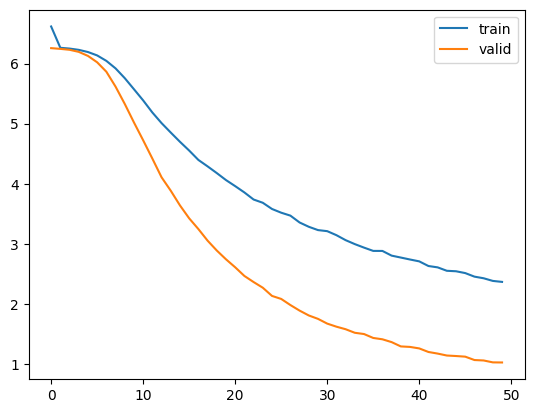

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_history.history['loss'])), train_history.history['loss'], label='train')
plt.plot(range(len(train_history.history['val_loss'])), train_history.history['val_loss'], label='valid')
plt.legend()

In [4]:
from skimage.io import imread

model_1 = tf.keras.models.load_model(checkpoint_path)
dataset_valid.class_names[np.argmax(model_1.predict(np.array([imread('data/test/PHILIPPINE EAGLE/1.jpg')])))]

NameError: name 'checkpoint_path' is not defined

In [13]:
model_1.evaluate(dataset_valid)

21/21 [==============================] - 30s 1s/step - loss: 1.0242 - accuracy: 0.8050


[1.024217128753662, 0.8049523830413818]

In [43]:
import csv
from hyperopt import hp
from hyperopt import STATUS_OK
from timeit import default_timer as timer

CHECKPOINTS_DIR = 'checkpoints'
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
TRIALS_FILE = os.path.join(CHECKPOINTS_DIR, 'trials.csv')

space = {
    'optim': hp.choice('optim', ['sgd', 'adam', 'adamw']),
    'init_lr': hp.loguniform('init_lr', np.log10(1e-4), np.log10(1e-1)),
    'dropout': hp.uniform('dropout', 0.3, 0.6),
}

def objective(params):
    global iteration
    iteration += 1

    checkpoint_path = os.path.join(
        CHECKPOINTS_DIR,
        ('birds_checkpoint'
            + f'__optiter-{iteration}__'
            + '__'.join(f'{k}-{v}' for k, v in params.items())
        )
    )
    optims = {
        'sgd': tf.keras.optimizers.SGD,
        'adam': tf.keras.optimizers.Adam,
        'adamw': tf.keras.optimizers.AdamW
    }
    optim = optims[params['optim']](params['init_lr'])
    dropout = params['dropout']

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        restore_best_weights = True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    augment = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    ])
    
    inputs = pretrained_model.input
    x = augment(inputs)
    
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    outputs = tf.keras.layers.Dense(525, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.F1Score(
                average='weighted', threshold=None, name='f1_score', dtype=None
            )        
        ]
    )

    start = timer()
    train_history = model.fit(
        dataset_mod_train,
        steps_per_epoch=len(dataset_mod_train),
        validation_data=dataset_valid,
        validation_steps=len(dataset_valid),
        epochs=2, #00,
        callbacks=[
            early_stopping,
            checkpoint_callback,
            reduce_lr
        ]
    )
    run_time = timer() - start
    loss = train_history.history['val_loss'][-1]
    accuracy = train_history.history['accuracy']
    val_accuracy = train_history.history['val_accuracy']
    f1_score = train_history.history['f1_score']
    val_f1_score = train_history.history['val_f1_score']
    epochs = len(train_history.history['val_loss'])

    trials_file = open(TRIALS_FILE, 'a')
    writer = csv.writer(trials_file)
    writer.writerow([loss, params, iteration, epochs, run_time])

    return {'loss': loss,
            'params': params,'iteration': iteration,
            'accuracy': accuracy, 'val_accuracy': val_accuracy,
            'f1_score': f1_score, 'val_f1_score': val_f1_score,
            'epochs': epochs,
            'train_time': run_time, 'status': STATUS_OK}

In [48]:
%%capture

from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin

trials_file = open(TRIALS_FILE, 'w')
writer = csv.writer(trials_file)
writer.writerow([
    'loss',
    'params', 'iteration',
    'accuracy', 'val_accuracy',
    'f1_score', 'val_f1_score',
    'epochs', 'train_time'
])
trials_file.close()

global  iteration
iteration = 0

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    trials=trials, 
    max_evals=2
)

best

INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-1__dropout-0.3370667955464227__init_lr-0.13495916561307417__optim-adamw/assets


INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-1__dropout-0.3370667955464227__init_lr-0.13495916561307417__optim-adamw/assets


INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-1__dropout-0.3370667955464227__init_lr-0.13495916561307417__optim-adamw/assets


INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-1__dropout-0.3370667955464227__init_lr-0.13495916561307417__optim-adamw/assets


INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-2__dropout-0.3511022323596323__init_lr-0.2092380919823702__optim-adam/assets


INFO:tensorflow:Assets written to: checkpoints/birds_checkpoint__optiter-2__dropout-0.3511022323596323__init_lr-0.2092380919823702__optim-adam/assets


In [47]:
trials.results

[{'loss': 6.307012557983398,
  'params': {'dropout': 0.5033352614409448,
   'init_lr': 0.1183189047709277,
   'optim': 'adamw'},
  'iteration': 1,
  'accuracy': [0.0006857143016532063, 0.0006857143016532063],
  'val_accuracy': [0.0019047618843615055, 0.0019047618843615055],
  'f1_score': [0.00020970992045477033, 3.901817763107829e-05],
  'val_f1_score': [7.24244091543369e-06, 7.24244091543369e-06],
  'epochs': 2,
  'train_time': 422.0488522199885,
  'status': 'ok'},
 {'loss': 6.205175399780273,
  'params': {'dropout': 0.39150067438919967,
   'init_lr': 0.026837551041364895,
   'optim': 'sgd'},
  'iteration': 2,
  'accuracy': [0.0022095239255577326, 0.003961904905736446],
  'val_accuracy': [0.004952380899339914, 0.011428571306169033],
  'f1_score': [0.0015236252220347524, 0.002244393341243267],
  'val_f1_score': [0.002579270862042904, 0.004504710901528597],
  'epochs': 2,
  'train_time': 566.5705093980068,
  'status': 'ok'}]

In [6]:
import tensorflow as tf
from skimage.io import imread

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def F1_score(y_true, y_pred):
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return 2 * ((precision_result * recall_result) / (precision_result + recall_result + 1e-6))

tf.keras.utils.get_custom_objects()['F1_score'] = F1_score

model_2 = tf.keras.models.load_model('data/EfficientNetB0-525-(224 X 224)- 98.97.h5', custom_objects={'F1_score':'F1_score'})
#model_2 = tf.keras.models.load_model('data/EfficientNetB0-525-(224 X 224)- 98.97.h5')
model_2.trainable = False
print(model_2)
dataset_valid.class_names[np.argmax(model_2.predict(np.array([imread('data/test/PHILIPPINE EAGLE/1.jpg')])))]

1/1 [==============================] - 1s 1s/step


'PHILIPPINE EAGLE'

In [10]:
model_1 = tf.keras.models.load_model('birds_checkpoint')
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'

In [7]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [33]:
model_2.evaluate(dataset_valid)

11/11 [==============================] - 83s 7s/step - loss: 0.3303 - accuracy: 0.9794 - F1_score: 0.9776


[0.33025839924812317, 0.9794363975524902, 0.9775663614273071]